In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (20, 6)})
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)


# events_data_test.csv - данные о действиях, которые совершают студенты со стэпами

step_id - id стэпа
user_id - анонимизированный id юзера
timestamp - время наступления события в формате unix date
action - событие, возможные значения:
discovered - пользователь перешел на стэп
viewed - просмотр шага,
started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
passed - удачное решение практического шага

In [300]:
df_events = pd.read_csv('data/events_data_test.csv')
df_events.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


# submission_data_test.csv - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
timestamp - время отправки решения в формате unix date
submission_status - статус решения
user_id - анонимизированный id юзера

In [301]:
df_submission = pd.read_csv('data/submission_data_test.csv')
df_submission.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [302]:
df_events.shape

(274768, 4)

In [303]:
df_submission.shape

(42261, 4)

In [304]:
list(df_submission)

['step_id', 'timestamp', 'submission_status', 'user_id']

In [305]:
df_submission.submission_status.value_counts()

wrong      21186
correct    21075
Name: submission_status, dtype: int64

In [306]:
df_submission.columns

Index(['step_id', 'timestamp', 'submission_status', 'user_id'], dtype='object')

In [307]:
df_events.columns

Index(['step_id', 'timestamp', 'action', 'user_id'], dtype='object')

In [308]:
df_events.isnull().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [309]:
df_submission.isnull().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

In [310]:
df_events[df_events.user_id == 24417].head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [311]:
df_events.action.value_counts()

viewed             118276
discovered          67268
passed              62357
started_attempt     26867
Name: action, dtype: int64

# Фичи, которые могут быть важны:
1. Количество уникальных степов у пользователя (sum step_id)
2. Количество просмотренных степов (viewed (просмотр))
3. Количество переходов на шаг (discovered (исследование))
4. Количество попыток решить шаг (started_attempt (начать_попытку))
5. Среднее время между шагами (timestamp)
6.

In [312]:
df_events.groupby('user_id', as_index=False).step_id.count().head()

,user_id,step_id
0,4,3
1,6,3
2,10,10
3,12,38
4,13,280


In [313]:
example_result = pd.read_csv('data/submission_example.csv')
example_result.shape

(6184, 2)

In [314]:
df_submission.groupby('user_id', as_index=False).step_id.count().head()

,user_id,step_id
0,12,1
1,13,65
2,15,40
3,21,127
4,35,42


In [315]:
# Возьмем код из степа 1_10 и 2_10 где мы формировали фичи
df_submission.submission_status.unique()

array(['wrong', 'correct'], dtype=object)

In [316]:
df_events.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [317]:
# Преобразуем дату в более читаемый и удобный для работы вид
df_events['date'] = pd.to_datetime(df_events.timestamp, unit='s')

In [318]:
df_events.head()

,step_id,timestamp,action,user_id,date
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47


In [319]:
df_events.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [320]:
df_events.date.min()

Timestamp('2018-05-20 03:59:01')

In [321]:
df_events.date.max()

Timestamp('2019-01-20 17:00:43')

In [322]:
df_events['day'] = df_events.date.dt.date

In [323]:
df_events.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


<AxesSubplot:xlabel='day'>

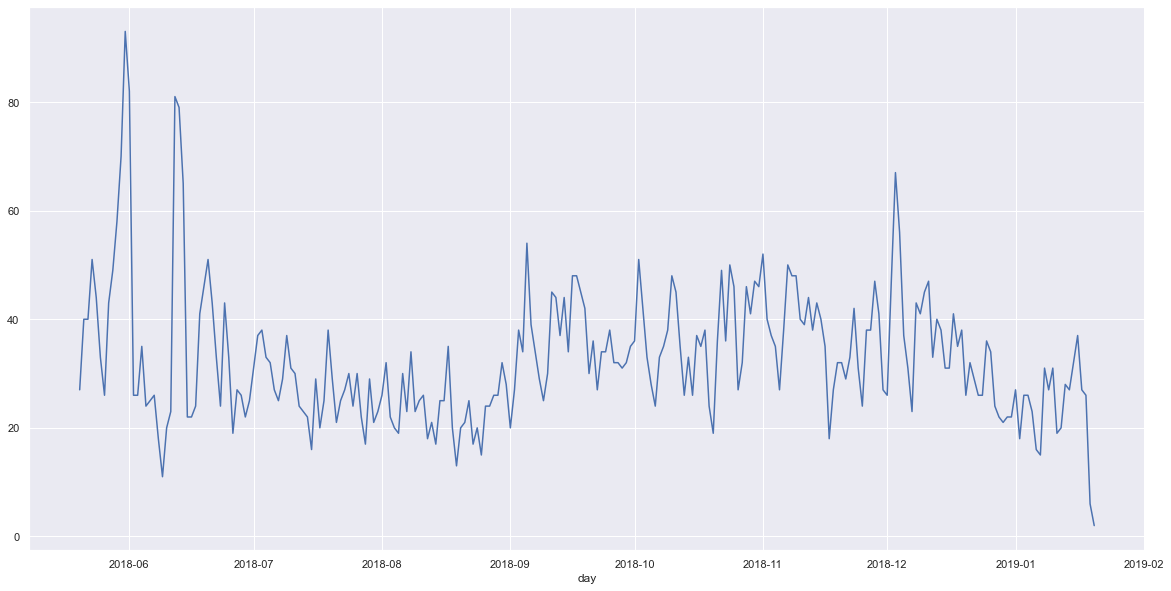

In [324]:
# посмотрим на уникальные user_id в день
# df_events.groupby('day').user_id.nunique().plot(figsize=(20,10))
df_events.groupby('day').user_id.nunique().plot(figsize=(20,10))

In [325]:
df_events.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [326]:
# Посмотрим сколько у нас пользователей с тем или иным набором баллов
users_data = df_events.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


<AxesSubplot:>

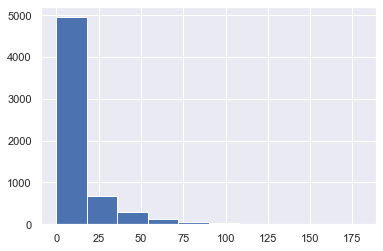

In [327]:
users_data.discovered.hist()

In [328]:
df_submission.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


<AxesSubplot:>

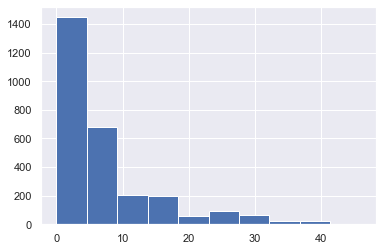

In [329]:
# Повторим те же действия с df_submission
users_scores = pd.pivot_table(df_submission,
                               values='step_id',
                               index='user_id',
                               columns='submission_status',
                               aggfunc='count',
                               fill_value=0).reset_index()
users_scores.correct.hist()

In [330]:
users_scores.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [331]:
users_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [332]:
X = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)
X.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0
3,12,11,9,4,14,1.0,0.0
4,13,70,70,35,105,29.0,36.0


In [333]:
X['finished_course'] = np.where(X.correct >= 40, 1, 0)
X.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,finished_course
0,4,1,1,0,1,0.0,0.0,0
1,6,1,1,0,1,0.0,0.0,0
2,10,2,2,0,6,0.0,0.0,0
3,12,11,9,4,14,1.0,0.0,0
4,13,70,70,35,105,29.0,36.0,0


In [334]:
X.dtypes

user_id              int64
discovered           int64
passed               int64
started_attempt      int64
viewed               int64
correct            float64
wrong              float64
finished_course      int32
dtype: object

In [335]:
x_train = X.drop('finished_course', axis='columns')
y_train = X.finished_course

In [336]:
clf = RandomForestClassifier(class_weight='balanced')

In [337]:
params = {'n_estimators': [10, 20, 30],'max_depth': [2, 5, 7, 10]}
grid_search_clr = GridSearchCV(clf, params, cv=5)

In [338]:
grid_search_clr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [339]:
grid_search_clr.best_params_

{'max_depth': 2, 'n_estimators': 20}

In [340]:
grid_search_clr.best_estimator_.feature_importances_

array([0.01283553, 0.12840402, 0.08401074, 0.06171852, 0.12538529,
       0.47818955, 0.10945634])

In [341]:
grid_search_clr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [342]:
y_pred = grid_search_clr.predict_proba(x_train)

In [343]:
# f1_score(y_pred=y_pred, y_true=y_train)
# y_pred = pd.Series(y_pred)
# y_pred.head()
roc_score = roc_auc_score(y_train, y_pred[:, 1])
roc_score

1.0

In [344]:
# pd.Series(y_pred).to_frame().to_csv('data/y_pred_ml_contest.csv')

In [345]:
test_y_pred = pd.read_csv('data/y_pred_ml_contest.csv')
test_y_pred.head()

,user_id,is_gone
0,4,0.0
1,6,0.0
2,10,0.0
3,12,0.0
4,13,0.0


In [346]:
pred_proba = grid_search_clr.predict_proba(x_train)[:, 1]
result_df = x_train.user_id.to_frame()
result_df['is_gone'] = pred_proba
result_df.set_index('user_id')
result_df.to_csv('data/y_pred_ml_contest.csv', index=False)

In [347]:
result_df.head()

,user_id,is_gone
0,4,0.105468
1,6,0.105468
2,10,0.021587
3,12,0.007848
4,13,0.180087


# Your ROC score is 0.4219648171397131

# Конец Курса Введение в Data Science на Stepik.org